# Electric Vehicle Adoption 

● Industry: auto industry <br>
● Business problem: The electric vehicle (EV) industry is booming, large and small players like GM, Tesla, Hyundai, Toyota are all racing to develop the latest technology to power EVs and the most attractive EVs. Governments are also encouraging EV penetration as a means to combat climate change, and providing incentives to companies and consumers to make the switch. How can we help encourage more people to join the movement, help companies understand their customer base and make strategic business decisions. 
<br>
● Specific problem : Predict if a person will buy an electric vehicle (EV). What are the characteristics of a person or household that are more likely to switch to an EV? 
<br>
● Why does this problem matter? Identifying groups that are more likely to switch to EVs help companies optimize their marketing. This also has broader implications for energy policy and climate change initiatives.
<br>
● What are the datasets that you will consider to solve this problem?<br>
Dataset: National Household Travel Survey <br>
Description: 4 datasets covers persons, household, trip, and vehicle info which contains variables for transport and demographics of people and households <br>
Major variables: vehicle type, age, income, education <br>
Collection method: A national survey of the US conducted up to 2017

### Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports and setup

#For system info
import os
#For data crunching
import numpy as np
from numpy.random import default_rng
import pandas as pd

#For plotting:
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots
from sklearn.preprocessing import LabelEncoder

#for stats
from scipy.stats import chisquare,chi2_contingency
import scipy.stats as stats

#for ML
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
#import xgboost as xgb

from sklearn.metrics import roc_curve, roc_auc_score, log_loss, confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn import svm

# import library & check version number
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from collections import Counter
#print(imblearn.__version__)

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
# grid search
from sklearn.model_selection import RandomizedSearchCV




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load datasets

In [ ]:
#Data dictionary
dictionary = pd.read_csv('/content/drive/My Drive/DS4A_Women/EV_data/dictionary_v1_2.csv')
#Household data
households = pd.read_csv('/content/drive/My Drive/DS4A_Women/EV_data/hhpub.csv')
#Vehicle data
vehicle = pd.read_csv('/content/drive/My Drive/DS4A_Women/EV_data/vehpub.csv')
#Personal data
persons = pd.read_csv('/content/drive/My Drive/DS4A_Women/EV_data/perpub.csv')
#Trip data
#trips = pd.read_csv('/content/drive/My Drive/DS4A_Women/EV_data/trippub.csv')

#Data codebook
code_files=['/content/drive/My Drive/DS4A_Women/EV_data/codebook_HH.csv',
            '/content/drive/My Drive/DS4A_Women/EV_data/codebook_PER.csv',
            '/content/drive/My Drive/DS4A_Women/EV_data/codebook_VEH.csv']
codebook = pd.concat((pd.read_csv(f) for f in code_files)).reset_index(drop=True)

# Fuel Stations Data
#Data contains the total number of charging stations in each state (assumed to be updated for 2017)
charging_stations = pd.read_csv('/content/drive/My Drive/DS4A_Women/EV_data/alt_fuel_stations.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Clean the codebook of information about variables

In [ ]:
#Look at the NaN counts (leftover from empty cells that were merged in the excel file)
codebook.isna().sum(axis = 0)

Name            2755
Label           2755
Type            2755
Length          2755
Code / Range       1
Frequency          1
Weighted           1
dtype: int64

In [ ]:
#We need to fill the NaN's. Forward fill the columns (which were merged cells in the excel)
fill_cols=['Name', 'Label','Type', 'Length']
df=codebook.copy()
for column in fill_cols:
    df[column]=df[column].fillna(method='ffill', axis=0)

#Check which rows have NaN
df.isnull().sum(axis = 0)
rows_with_nan = [index for index, row in df.iterrows() if row.isnull().any()]
print(rows_with_nan)
print(df.iloc[rows_with_nan])

[1856]
        Name                             Label  ... Frequency  Weighted
1856  YRTOUS  Year of Arrival in United States  ...       NaN       NaN

[1 rows x 7 columns]


In [ ]:
# Codebook has a Code/Range column that needs to be split on '=' 
# new data frame with split value columns
new = df["Code / Range"].str.split("=", n = 1, expand = True)
  
# making separate first name column from new data frame
df["Code"]= new[0]
  
# making separate last name column from new data frame
df["Meaning"]= new[1]
  
# Dropping old Name columns
df.drop(columns =["Code / Range"], inplace = True)
# Replace old codebook with new
codebook_clean=df#.apply(pd.to_numeric)#, errors='ignore')
#codebook_clean[['Type', 'Frequency','Weighted','Code']] = df[['Type', 'Frequency','Weighted','Code']].astype(float)  
#Display new codebook
codebook_clean.head()
#codebook_clean.unique

,Name,Label,Type,Length,Frequency,Weighted,Code,Meaning
0,BIKE,Frequency of Bicycle Use for Travel,C,2.0,"14,661","13,787,962",-9,Not ascertained
1,BIKE,Frequency of Bicycle Use for Travel,C,2.0,10,"10,908",-8,I don't know
2,BIKE,Frequency of Bicycle Use for Travel,C,2.0,5,"32,672",-7,I prefer not to answer
3,BIKE,Frequency of Bicycle Use for Travel,C,2.0,"1,870","1,979,683",01,Daily
4,BIKE,Frequency of Bicycle Use for Travel,C,2.0,"5,363","4,961,863",02,A few times a week


### Look at the number of observations and variables per dataset

In [ ]:
datasets=[households,vehicle,persons]
pd.DataFrame({'dataset':['households','vehicle','persons'],
              'variables':[set.shape[1] for set in datasets],
              'observations':[set.shape[0] for set in datasets]})
    

,dataset,variables,observations
0,households,58,129696
1,vehicle,60,256115
2,persons,121,264234


### Create an accessible data dictionary

In [ ]:
df=dictionary.copy()
df=df.drop(['Type','Length','HH','PER','VEH'],axis=1)
data_dict=df.set_index('Name')['Label'].to_dict()

print('Total variables:',len(data_dict.values()))

Total variables: 244


### Look at variables labels

In [ ]:
#Vehicle variables
#[dictionary.loc[dictionary.Name==i,'Label'].values[0] for i in vehicle]
# vehicle_vars=[data_dict.get(i) for i in vehicle]
# vehicle_vars

In [ ]:
#person variables
# person_vars=[data_dict.get(i) for i in persons]
# person_vars

In [ ]:
#household variables
# house_vars=[data_dict.get(i) for i in households]
# house_vars

### Look at vehicel summary statistics 

In [ ]:
#vehicle.describe()

### Filter and Subsetting the Vehicle Data

We want to look at only the last 3 years: 2015,2016,2017 of vehicle models (new cars) to capture recent trends
Note: this reduces our date from 256115 vehicle data points to 33981 data points, or keeps only 13.3% of vehicle data

In [ ]:
# Keep last three years of survey data to identify trends
years = [2017, 2016, 2015]
vehicle = vehicle[vehicle['VEHYEAR'].isin(years)]

In [ ]:
# Filter vehicle age to 3 years to illustrate the vehicle adoption trend and potential vehicle market
age = [1,2,3]
vehicle = vehicle[vehicle['VEHAGE'].isin(age)]

In [ ]:
# Keep only valid responses
# 'Skip' Response was kept because that was a bulk of the responses
vehicle_type = [4,3,2,1,97,-1]
vehicle = vehicle[vehicle['HFUEL'].isin(vehicle_type)]
print('Length of Data:', len(vehicle))

Length of Data: 33981


In [ ]:
codebook_clean[codebook_clean['Name'] == 'HFUEL']

,Name,Label,Type,Length,Frequency,Weighted,Code,Meaning
1990,HFUEL,Type of Hybrid Vehicle,C,2.0,131,"81,744",-9,Not ascertained
1991,HFUEL,Type of Hybrid Vehicle,C,2.0,4,683,-8,I don't know
1992,HFUEL,Type of Hybrid Vehicle,C,2.0,"249,699","217,812,839",-1,Appropriate skip
1993,HFUEL,Type of Hybrid Vehicle,C,2.0,34,"19,485",01,Biodiesel
1994,HFUEL,Type of Hybrid Vehicle,C,2.0,482,"358,528",02,"Plug-in Hybrid (gas/electric e.g., Chevy Volt)"
1995,HFUEL,Type of Hybrid Vehicle,C,2.0,607,"423,096",03,Electric (e.g. Nissan Leaf)
1996,HFUEL,Type of Hybrid Vehicle,C,2.0,"4,996","3,743,495",04,"Hybrid (gas/electric, not plug-in e.g., Toyota..."
1997,HFUEL,Type of Hybrid Vehicle,C,2.0,162,"139,075",97,Some other fuel


### Identify Electric Vehicles (EV)

Variable of Interest is 'HFUEL': codes what type of fuel the vehicle uses. 
EV includes the BEV and PHEV (plug in hybrid)  that use the battery. We can look at fully electric only (03-BEV) or all EVs (02,03,04)<br>
- 02	Plug-in Hybrid (gas/electric e.g., Chevy Volt)	
- 03	Electric (e.g. Nissan Leaf)	
- 04	Hybrid (gas/electric, not plug-in e.g., Toyota Prius)
<br>
There are 607 BEV in the data, 482 PHEV and  4996 not plug in hybrid

In [ ]:
vehicle = vehicle.reset_index(drop=True)

In [ ]:
ev = [4,3,2]
print('% BEV in data',100*len(vehicle[vehicle['HFUEL']==3])/vehicle['HFUEL'].value_counts().sum())
print('% EV in data',100*len(vehicle[vehicle['HFUEL'].isin(ev)])/vehicle['HFUEL'].value_counts().sum())


% BEV in data 0.7239339630970248
% EV in data 3.8698095994820636


In [ ]:
# Classify our target variable
vehicle['HFUEL_target'] = np.where(vehicle['HFUEL'].isin(ev),1,0)
vehicle['HFUEL_target'].value_counts()
vehicle = vehicle.drop(columns = 'HFUEL')

In [ ]:
print(vehicle.shape)
vehicle['HFUEL_target'].value_counts()

(33981, 60)


0    32666
1     1315
Name: HFUEL_target, dtype: int64

### Merge NHS dataset on 'HOUSEID' and 'PERSONID' variables 

In [ ]:
# Merging our Person, Vehicle, Household datasets
houseid = vehicle['HOUSEID'].unique()
persons = persons[persons['HOUSEID'].isin(houseid)].reset_index(drop = True)
households = households[households['HOUSEID'].isin(houseid)].reset_index(drop = True)
df_all = vehicle.merge(persons, on=['HOUSEID','PERSONID'], how = 'left')
df_all = df_all.merge(households, on = ['HOUSEID'], how = 'left')

### Selecting key variables to investigate

In [ ]:
# Variables we chose as a group
variables_all =[
'Odometer Reading',
'Vehicle Main Driver',
'Home Ownership',
'Count of household members',
'Count of household vehicles',
'Household income',
'Number of drivers in household',
'Household state',
'State FIPS for household address',
'Count of adult household members at least 18 years old',
'Number of workers in household',
'Self-reported annualized mile estimate',
'Urban area size where home address is located',
'Household in urban/rural area',
'Race of household respondent',
'Hispanic status of household respondent',
'Household Identifier',
'Person Identifier',
'Household Vehicle Identifier Used on Trip',
'Annualized fuel cost in US cents per equivalent gallon',
"Category of population density (persons per square mile) in the census block group of the household's home location",
'Annual fuel consumption in US gallons',
'Annual fuel expenditures in US dollars',
'Age (imputed)',
'Educational Attainment',
'Hispanic or Latino Origin',
'Relationship', 
'Gender (imputed)',
'Race',
'Primary Activity in Previous Week',
'Full-Time or Part-Time Worker',
'Mode to Work',
'Job Category',
'Student Status',
'Count of Walk Trips',
'Count of Walk Trips for Exercise',
'Count of Bike Trips',
'Count of Bike Trips for Exercise',
'Count of Bike Share Program Usage',
'Count of Public Transit Usage',
'Count of Motorcycle or Moped Trips',
'Count of Car Share Program Usage',
'Count of Rideshare App Usage',
'Count of People in Vehicle to Work',
'Trip Time to Work in Minutes',
'Option of Working from Home',
'Opinion of Health',
"Road network distance, in miles, between respondent's home location and work location, sourced using Google Distance Matrix API (https://maps.googleapis.com/maps/api/distancematrix/)",
'Level of Physical Activity',
'Frequency of internet use',
'Price of Gasoline Affects Travel',
'Travel is a Financial Burden',
'MSA heavy rail status for household']

In [ ]:
# Looking at Invalid Responses using all the variables we chose. Variables were dropped based off of high prorportion of invalid responses.
vars_all = list()
for i in range(len(variables_all)):
    var = list(data_dict.keys())[list(data_dict.values()).index(variables_all[i])]
    vars_all.append(var)
final_dat_var_all = df_all[vars_all]
invalid = [-8, -7, -1, -9, 97,-77,-88,'-8', '-7', '-1', '-9', '97','-77','-88']
invalid_responses = final_dat_var_all.isin(invalid).sum().to_frame()
invalid_var=(invalid_responses[invalid_responses[0] >200]).T.columns
(invalid_responses[invalid_responses[0] >200])

,0
OD_READ,4192
WHOMAIN,449
HHFAMINC,1106
ANNMILES,5719
HH_RACE,588
PERSONID,449
GSCOST,234
GSYRGAL,231
GSTOTCST,234
R_RACE,737


In [ ]:
# Reassessing more variables
reassess = ['Level of Physical Activity', 
'Frequency of internet use', 
'Relationship']

reassess_var = list()

for i in range(len(reassess)):
    var = list(data_dict.keys())[list(data_dict.values()).index(reassess[i])]
    vars_all.append(var)
    reassess_var.append(var)
reassess_var
#vars_all

['PHYACT', 'WEBUSE17', 'R_RELAT']

In [ ]:
vars_final=list(set(vars_all)-set(invalid_var))#+set(reassess_var)
vars_final

['RIDESHARE',
 'HOUSEID',
 'URBRUR',
 'HOMEOWN',
 'R_AGE_IMP',
 'R_RELAT',
 'PTUSED',
 'HHSIZE',
 'HHSTFIPS',
 'RAIL',
 'HHVEHCNT',
 'WRKCOUNT',
 'DRVRCNT',
 'CARSHARE',
 'EDUC',
 'HH_HISP',
 'R_HISP',
 'PRICE',
 'HBPPOPDN',
 'URBANSIZE',
 'R_SEX_IMP',
 'NWALKTRP',
 'VEHID',
 'HHSTATE',
 'WEBUSE17',
 'HEALTH',
 'PHYACT',
 'NBIKETRP',
 'NUMADLT']

In [ ]:
variables =[
#'Odometer Reading',
#'Vehicle Main Driver',
'Home Ownership',
#'Count of household members',
'Count of household vehicles',
'Household income',
#'Number of drivers in household',
'Household state',
#'State FIPS for household address',
#'Count of adult household members at least 18 years old',
'Number of workers in household',
# 'Self-reported annualized mile estimate', ####5719 invalid responses
'Urban area size where home address is located', 
#'Household in urban/rural area', 
#'Race of household respondent',
#'Hispanic status of household respondent',
'Household Identifier',
'Person Identifier', #PERSONID is number 1-10 to identify person in HOUSEID
#'Household Vehicle Identifier Used on Trip',
'Annualized fuel cost in US cents per equivalent gallon',
#"Category of population density (persons per square mile) in the census block group of the household's home location",
#'Annual fuel consumption in US gallons',
#'Annual fuel expenditures in US dollars',
'Age (imputed)', 
'Educational Attainment',
#'Hispanic or Latino Origin',
#'Relationship',  #SZ: reassess, dropped because it's the relationship of someone to person 01, not indication or marital status
'Gender (imputed)',
'Race',
# 'Primary Activity in Previous Week', ##### 1238 invalid responses
#'Full-Time or Part-Time Worker',
#'Mode to Work',
#'Job Category', ####13104 MISSING/INVALID VALUES
#'Student Status',
#'Count of Walk Trips',
#'Count of Walk Trips for Exercise',
#'Count of Bike Trips',
#'Count of Bike Trips for Exercise',
#'Count of Bike Share Program Usage',
#'Count of Public Transit Usage',
#'Count of Motorcycle or Moped Trips',
#'Count of Car Share Program Usage', #### want to focus on the rideshare app instead of other counts of other trans means.
'Count of Rideshare App Usage',
#'Count of People in Vehicle to Work',
#'Trip Time to Work in Minutes',
#'Option of Working from Home',
#'Opinion of Health',
#"Road network distance, in miles, between respondent's home location and work location, sourced using Google Distance Matrix API (https://maps.googleapis.com/maps/api/distancematrix/)",
'Level of Physical Activity', #SZ: reassess
'Frequency of internet use', #SZ: reassess
'Price of Gasoline Affects Travel']
#'Travel is a Financial Burden'
#'MSA heavy rail status for household'

Variables commented out were dropped due to one of these reasons:
1. Heatmap shows high correlation between another variable (< 0.7)
2. There is a similar variable with another variable in the list (i.e. HH Race and other race indicators)
3. There is a high number of invalid responses 

In [ ]:
# Finalize the Variables we want and drop NAs

vars = list()
for i in range(len(variables)):
    var = list(data_dict.keys())[list(data_dict.values()).index(variables[i])]
    vars.append(var)
vars = vars+['HFUEL_target']
#vars = vars_final+['HFUEL_target']
final_data0 = df_all[vars]

final_data0.isna().sum()

HOMEOWN           0
HHVEHCNT          0
HHFAMINC          0
HHSTATE           0
WRKCOUNT          0
URBANSIZE         0
HOUSEID           0
PERSONID          0
GSCOST            0
R_AGE_IMP       449
EDUC            449
R_SEX_IMP       449
R_RACE          449
RIDESHARE       449
PHYACT          449
WEBUSE17          0
PRICE             0
HFUEL_target      0
dtype: int64

We have 18 features (minus our target variable and identification features)

### Merge cleaned NHS dataset with Charging station dataset

In [ ]:
# Merging Charging Stations Counts to Final Dataset
charging_stations['counts'] = charging_stations['State'].map(charging_stations['State'].value_counts())
charging_stations = charging_stations[['counts', 'State']]
charging_stations = charging_stations.drop_duplicates('State').reset_index(drop = True)
final_data = final_data0.rename(columns = {'HHSTATE':'State'})
final_data = pd.merge(final_data, charging_stations[['State', 'counts']], on = ['State'], how = 'left')
final_data1 = final_data.rename(columns = {'counts':'CHARSTACT'}) #Charging Station Count

print(final_data1.shape)

(33981, 19)


### Simplifying variables code categories in preparation for One-Hot Encoding

In [ ]:
#Remove rows with invalid response choices
#df=final_data1.copy()
#for var in final_data1.columns:
#    df.drop(df[df[var].isin(invalid)].index, inplace = True)
#print(df.shape)
#final_data2=df.copy()
#final_data2['HFUEL_target'].value_counts()

#Look at the distinct values/categories in each variable
#df.apply(np.unique,axis=0)
#final_data=df.copy()
#final_data2.apply(np.unique,axis=0)

#Look at the NaN values
#final_data2.isna().sum()

#### Determine the numerical vs categorical variables

In [ ]:
#Numerical columns
num_var=['HHVEHCNT', 'WRKCOUNT','GSCOST', 'R_AGE_IMP', 'RIDESHARE','CHARSTACT']
#Categorical columns
cat_var=['HOMEOWN', 'HHFAMINC', 'State', 'URBANSIZE', 'EDUC','R_SEX_IMP', 'R_RACE','PHYACT', 'WEBUSE17',
       'PRICE', 'HFUEL_target']

In [ ]:
#Create a df for the categorical variable dictionaries for easy access
cat_df = pd.DataFrame()
for var in cat_var:
    df=codebook_clean[codebook_clean['Name']==var]
    df=df.drop(['Name','Label','Type','Length','Frequency','Weighted'],axis=1)
    df=df.apply(pd.to_numeric, errors='ignore',axis=0)
    cat_df[var]=[df.set_index('Code')['Meaning'].to_dict()]
cat_df

,HOMEOWN,HHFAMINC,State,URBANSIZE,EDUC,R_SEX_IMP,R_RACE,PHYACT,WEBUSE17,PRICE,HFUEL_target
0,"{-8: 'I don't know', -7: 'I prefer not to answ...","{-9: 'Not ascertained', -8: 'I don't know', -7...",{},"{1: '50,000 - 199,999', 2: '200,000 - 499,999'...","{-8: 'I don't know', -7: 'I prefer not to answ...","{1: 'Male', 2: 'Female'}","{-8: 'Don't know', -7: 'Refused', 1: 'White', ...","{-9: 'Not ascertained', -8: 'I don't know', -7...","{-9: 'Not ascertained', -7: 'I prefer not to a...","{-9: 'Not ascertained', -8: 'I don't know', -7...",{}


### Look at the variables and how we can simplify them

In [ ]:
# Household Family income
cat_df['HOMEOWN'][0]
#Add variable for minimum income level, derived from HHFAMINC
HOMEOWN={-8: 'Not Own',
 -7: 'Not Own',
 1: 'Own',
 2: 'Not Own',
 97: 'Not Own'}

In [ ]:
# Household Family income
cat_df['HHFAMINC'][0]
#Add variable for minimum income level, derived from HHFAMINC
HHFAMINC={
    -9: None,
 -8: None,
 -7: None,
    1: 0,
 2: 10000,
 3: 15000,
 4: 25000,
 5: 35000,
 6: 50000,
 7: 75000,
 8: 100000,
 9: 125000,
 10: 150000,
 11: 200000}

In [ ]:
#Add variable for minimum city population, derived from URBANSIZE
cat_df['URBANSIZE'][0]
URBANSIZE={
1: 50000,
 2: 200000,
 3: 500000,
 4: 1000000,
 5: 1000000,
 6: 0}

In [ ]:
cat_df['EDUC'][0]
#Add variable for simplied education level, derived from EDUC
EDUC={
    -8: None,
 -7: None,
 -1: None,
1: '<=High school',
 2: '<=High school',
 3: "College degree",
 4: "College degree",
 5: 'Advanced degree'}

In [ ]:
cat_df['R_SEX_IMP'][0]
R_SEX_IMP={1: 'Male', 2: 'Female'}

In [ ]:
cat_df['R_RACE'][0]
R_RACE={-8: None,
 -7: None,
 1: 'White',
 2: 'Black',
 3: 'Asian',
 4: 'Other',
 5: 'Other',
 6: 'Other',
 97: 'Other'}

In [ ]:
# Amount of physcial activity
cat_df['PHYACT'][0]
PHYACT={
    -9: 'Little',
 -8: 'Little',
 -7: 'Little',
 1: 'Little',
 2: 'Moderate',
 3: 'Vigorous'}

In [ ]:
#How often use the web
cat_df['WEBUSE17'][0]
WEBUSE17={
    -9: None,
 -7: None,
 1: 'Frequent',
 2: 'Frequent',
 3: 'Infrequent',
 4: 'Infrequent',
 5: 'Infrequent'}

In [ ]:
# Question if Price of Gasoline Affects Travel
cat_df['PRICE'][0]
PRICE={
    -9: None,
 -8: None,
 -7: None,
 1: 'YES',
 2: 'YES',
 3: 'NEUTRAL',
 4: 'NO',
 5: 'NO'}

In [ ]:
changed_cat_vars=['HOMEOWN','HHFAMINC','URBANSIZE','EDUC','R_SEX_IMP','R_RACE','PHYACT','WEBUSE17','PRICE']
changed_var_dict=[HOMEOWN, HHFAMINC, URBANSIZE, EDUC,R_SEX_IMP, R_RACE,PHYACT, WEBUSE17,PRICE]

#dict_vars=[Min_Fam_Inc,Min_city_pop,Educ_lev,Race,Exercise,Web_use,Gas_price_effect]
#new_vars=['Min_Fam_Inc','Min_city_pop','Educ_lev','Race','Exercise','Web_use','Gas_price_effect']
#d['new'] = d['new'].fillna('Else')

In [ ]:
changed_var_dict[1].get(-9)

In [ ]:
df=final_data1.copy()
for i in range(len(changed_cat_vars)):
    #df[new_vars[i]] = np.nan
    var_dict=changed_var_dict[i]
    for key in var_dict.keys():
        df[changed_cat_vars[i]].mask(df[changed_cat_vars[i]] == key, var_dict.get(key), inplace=True)
        
#Rename columns
df.rename(columns={'HHFAMINC': 'Min_Fam_Inc', 'URBANSIZE': 'Min_city_pop','R_SEX_IMP': 'Gender',
                   'PHYACT':'Exercise','WEBUSE17':'Web_use','PRICE':'Gas_price_effect'}, inplace=True)
df

,HOMEOWN,HHVEHCNT,Min_Fam_Inc,State,WRKCOUNT,Min_city_pop,HOUSEID,PERSONID,GSCOST,R_AGE_IMP,EDUC,Gender,R_RACE,RIDESHARE,Exercise,Web_use,Gas_price_effect,HFUEL_target,CHARSTACT
0,Own,2,35000.0,WI,0,200000,30000029,1,2.266500,72.0,College degree,Male,White,0.0,Moderate,Frequent,NEUTRAL,0,477
1,Own,2,150000.0,PA,1,500000,30000039,1,2.440167,82.0,Advanced degree,Male,White,0.0,Moderate,Frequent,NO,0,1109
2,Own,2,200000.0,CA,2,200000,30000041,2,2.858917,40.0,<=High school,Female,White,7.0,Vigorous,Frequent,NO,1,14129
3,Not Own,2,75000.0,TX,2,200000,30000145,2,2.126167,52.0,College degree,Female,Other,0.0,Moderate,Frequent,YES,0,2241
4,Own,1,25000.0,WI,0,1000000,30000271,1,2.266500,76.0,College degree,Female,White,0.0,Moderate,Frequent,NO,0,477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33976,Own,1,NaN,NC,0,0,40793993,1,2.312750,73.0,Advanced degree,Female,White,0.0,Moderate,Frequent,NO,0,1068
33977,Not Own,1,75000.0,CA,1,1000000,40794003,1,2.858917,37.0,College degree,Female,White,4.0,Moderate,Frequent,NO,0,14129
33978,Not Own,1,25000.0,TX,0,200000,40794037,1,2.126167,68.0,College degree,Male,White,0.0,Little,Frequent,NO,0,2241
33979,Not Own,2,100000.0,GA,0,1000000,40794073,1,2.312750,41.0,Advanced degree,Female,White,0.0,Vigorous,Frequent,NO,0,1561


Generation definitions: <br>
Source: https://web.archive.org/web/20180331061858/https://www.pewresearch.org/topics/generations-and-age/
Age in 2018:
- Gen Z: 1997 – 2012 Age: 5 – 21
- Millennials: 1981-96 Age: 22-37
- Gen X: 1965-1980 Age: 38-53
- Boomers: 1946-1964 Age: 54-72
- Silent: 1928-1945 Age: 73-90

In [ ]:
df['Generation'] = pd.cut(df['R_AGE_IMP'], bins = [0,21,37,53,72,100], right = False, labels = ['Gen Z', 'Millennials', 'Gen X','Boomers','Silent'])       
#df['EV']=np.zeros()
#df['EV'].mask(df[HFUEL_target] == 1, 'EV', inplace=True)
final_data2=df.copy()

In [ ]:
#check for NaN values: 449 rows, relatively small compared with total number of sample: 33,000+ rows, therefore, drop NaN
final_data2.isna().sum(axis=0) #449
final_data3=final_data2.dropna()
final_data3.shape 
final_data=final_data3.drop(columns=['HOUSEID', 'PERSONID'])

In [ ]:
# Try filling the NaN with the mode, Decided not to
#df=final_data2.fillna(final_data2.mode().iloc[0])
#df.isna().sum()## convert df to a series
#final_data=df.copy()

In [ ]:
#Original EVs=1315, after dropNaN EVs= 1305, so preserved most of the EVs
print(final_data.shape)
final_data['HFUEL_target'].value_counts()

(32190, 18)


0    30921
1     1269
Name: HFUEL_target, dtype: int64

In [ ]:
# Dataset without One Hot Encoding
final_data.shape

(32190, 18)

In [ ]:
#Data description :
final_data.describe()

,HHVEHCNT,Min_Fam_Inc,WRKCOUNT,Min_city_pop,GSCOST,R_AGE_IMP,RIDESHARE,HFUEL_target,CHARSTACT
count,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.00000,32190.000000,32190.000000
mean,2.453743,91586.051569,1.274868,415880.708295,2.361762,53.479372,0.35452,0.039422,3874.279497
std,1.221152,55964.288512,0.949892,447030.748568,0.914301,15.831046,1.70864,0.194600,4897.597025
min,1.000000,0.000000,0.000000,0.000000,-9.000000,14.000000,-9.00000,0.000000,49.000000
25%,2.000000,50000.000000,1.000000,0.000000,2.266500,41.000000,0.00000,0.000000,889.000000
50%,2.000000,75000.000000,1.000000,200000.000000,2.312750,55.000000,0.00000,0.000000,2241.000000
75%,3.000000,125000.000000,2.000000,1000000.000000,2.465333,66.000000,0.00000,0.000000,2867.000000
max,12.000000,200000.000000,7.000000,1000000.000000,9.858750,92.000000,70.00000,1.000000,14129.000000


In [ ]:
#Description of variables by outcome (mean (sd)): 
final_data.groupby(["HFUEL_target"]).describe()
#final_data.groupby(["HFUEL_target"])[["OD_READ","HOMEOWN","HHVEHCNT","HHFAMINC", "WRKCOUNT","URBANSIZE","GSCOST","R_AGE_IMP","EDUC","R_RELAT","R_SEX_IMP","R_RACE","RIDESHARE", "PHYACT","WEBUSE17", "PRICE"]].describe()

HHVEHCNT                      ... CHARSTACT                  
                count      mean       std  ...       50%      75%      max
HFUEL_target                               ...                            
0             30921.0  2.454707  1.223223  ...    2241.0   2867.0  14129.0
1              1269.0  2.430260  1.169768  ...    2867.0  14129.0  14129.0

[2 rows x 64 columns]

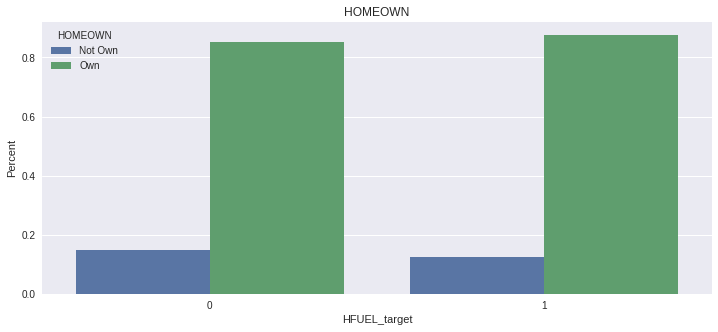

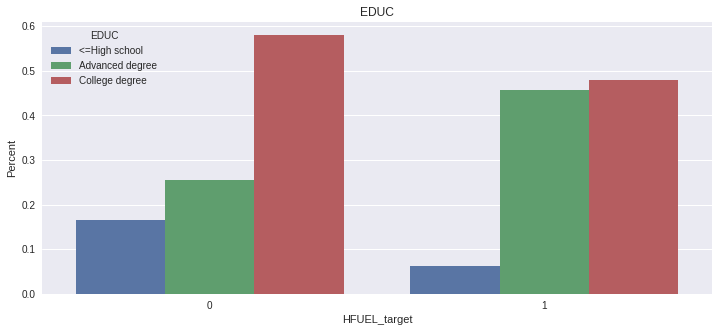

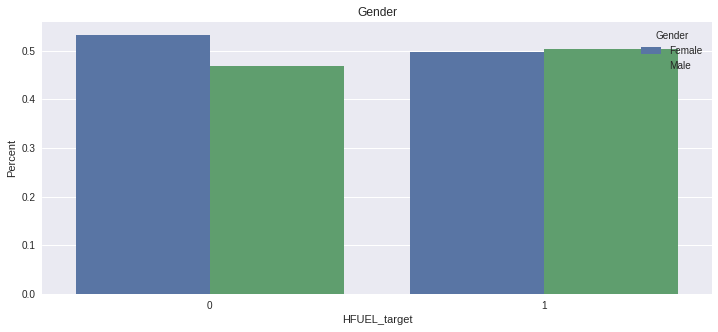

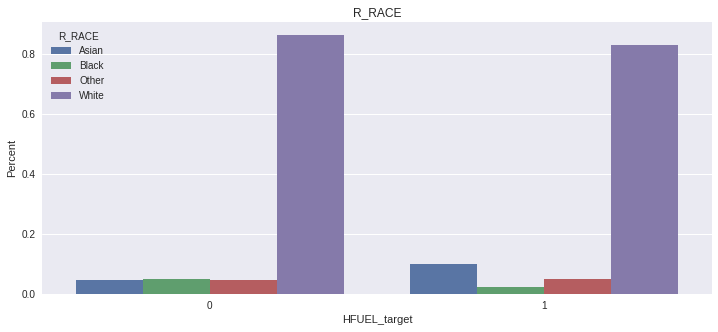

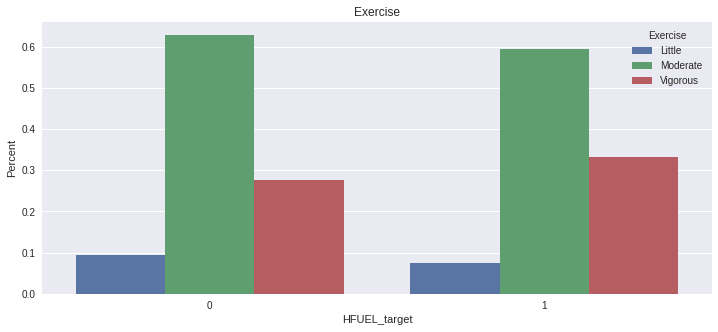

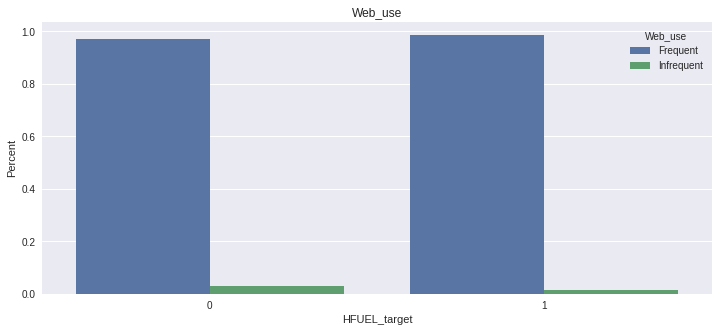

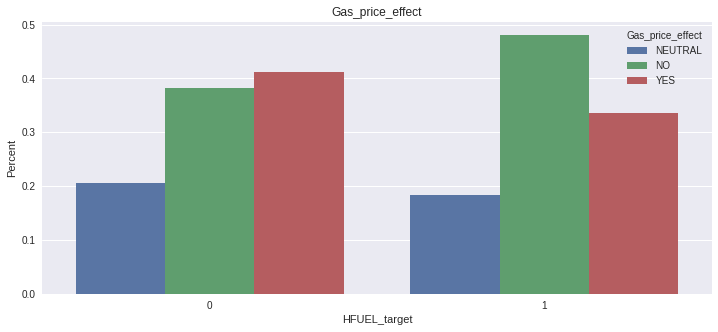

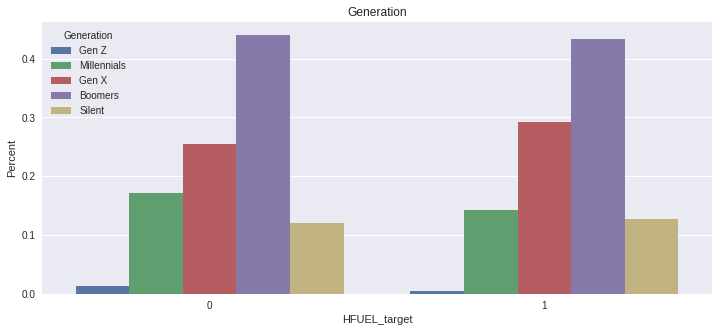

In [ ]:
#Variable count by outcome: 
barplot_var=['HOMEOWN', 'EDUC', 'Gender', 'R_RACE','Exercise', 'Web_use', 'Gas_price_effect','Generation']

for var in barplot_var:
    ct=pd.crosstab(final_data['HFUEL_target'],final_data[var],margins=False,normalize='index')
    # now stack and reset
    stacked = ct.stack().reset_index().rename(columns={0:'Percent'})
    # plot grouped bar chart
    plt.figure(figsize=(12,5))
    plt.title(var)
    p = sns.barplot(hue=stacked[var], y=stacked.Percent, x=stacked['HFUEL_target'])
    #sns.move_legend(p, bbox_to_anchor=(1, 1.02), loc='upper left')

### One Hot Encoding

In [ ]:
# One Hot Encoded Data with state
ohe_vars=['HOMEOWN', 'State', 'EDUC', 'Gender', 'R_RACE','Exercise', 'Web_use', 'Gas_price_effect','Generation']
# One Hot Encoded Data with out state
#ohe_vars=['HOMEOWN', 'EDUC', 'Gender', 'R_RACE','Exercise', 'Web_use', 'Gas_price_effect','Generation']
ohe_final_data = pd.get_dummies(final_data, columns=ohe_vars,dtype=int)
ohe_final_data.head()

,HHVEHCNT,Min_Fam_Inc,WRKCOUNT,Min_city_pop,GSCOST,R_AGE_IMP,RIDESHARE,HFUEL_target,CHARSTACT,HOMEOWN_Not Own,HOMEOWN_Own,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,...,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,EDUC_<=High school,EDUC_Advanced degree,EDUC_College degree,Gender_Female,Gender_Male,R_RACE_Asian,R_RACE_Black,R_RACE_Other,R_RACE_White,Exercise_Little,Exercise_Moderate,Exercise_Vigorous,Web_use_Frequent,Web_use_Infrequent,Gas_price_effect_NEUTRAL,Gas_price_effect_NO,Gas_price_effect_YES,Generation_Gen Z,Generation_Millennials,Generation_Gen X,Generation_Boomers,Generation_Silent
0,2,35000.0,0,200000,2.266500,72.0,0.0,0,477,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1
1,2,150000.0,1,500000,2.440167,82.0,0.0,0,1109,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1
2,2,200000.0,2,200000,2.858917,40.0,7.0,1,14129,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0
3,2,75000.0,2,200000,2.126167,52.0,0.0,0,2241,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0
4,1,25000.0,0,1000000,2.266500,76.0,0.0,0,477,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1


In [ ]:
ohe_final_data.describe()

,HHVEHCNT,Min_Fam_Inc,WRKCOUNT,Min_city_pop,GSCOST,R_AGE_IMP,RIDESHARE,HFUEL_target,CHARSTACT,HOMEOWN_Not Own,HOMEOWN_Own,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,...,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,EDUC_<=High school,EDUC_Advanced degree,EDUC_College degree,Gender_Female,Gender_Male,R_RACE_Asian,R_RACE_Black,R_RACE_Other,R_RACE_White,Exercise_Little,Exercise_Moderate,Exercise_Vigorous,Web_use_Frequent,Web_use_Infrequent,Gas_price_effect_NEUTRAL,Gas_price_effect_NO,Gas_price_effect_YES,Generation_Gen Z,Generation_Millennials,Generation_Gen X,Generation_Boomers,Generation_Silent
count,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.00000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,...,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000,32190.000000
mean,2.453743,91586.051569,1.274868,415880.708295,2.361762,53.479372,0.35452,0.039422,3874.279497,0.148027,0.851973,0.001118,0.002454,0.001336,0.022491,0.181081,0.003293,0.002112,0.001212,0.002423,0.013203,0.060702,0.001584,0.019913,0.001864,0.007518,0.002641,0.001212,0.002423,0.001398,0.003262,0.010997,0.002330,0.007673,0.004163,0.003790,0.001025,0.001553,0.062224,0.002019,...,0.001429,0.158341,0.008139,0.008357,0.001771,0.008760,0.001802,0.046381,0.002485,0.003541,0.219167,0.002268,0.005250,0.003635,0.003697,0.081019,0.001678,0.002112,0.160485,0.263063,0.576452,0.530848,0.469152,0.046629,0.046754,0.045884,0.860733,0.094346,0.626872,0.278782,0.972321,0.027679,0.204567,0.385927,0.409506,0.012675,0.170301,0.255576,0.440230,0.121218
std,1.221152,55964.288512,0.949892,447030.748568,0.914301,15.831046,1.70864,0.194600,4897.597025,0.355133,0.355133,0.033424,0.049480,0.036525,0.148278,0.385091,0.057291,0.045914,0.034787,0.049166,0.114144,0.238787,0.039773,0.139704,0.043134,0.086380,0.051319,0.034787,0.049166,0.037364,0.057021,0.104291,0.048214,0.087261,0.064386,0.061447,0.032002,0.039382,0.241566,0.044891,...,0.037776,0.365066,0.089851,0.091033,0.042043,0.093188,0.042410,0.210312,0.049791,0.059406,0.413689,0.047568,0.072268,0.060179,0.060690,0.272868,0.040924,0.045914,0.367061,0.440303,0.494128,0.499055,0.499055,0.210847,0.211114,0.209236,0.346230,0.292314,0.483643,0.448407,0.164055,0.164055,0.403391,0.486821,0.491750,0.111868,0.375903,0.436191,0.496422,0.326385
min,1.000000,0.000000,0.000000,0.000000,-9.000000,14.000000,-9.00000,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [ ]:
ohe_final_data.columns

Index(['HHVEHCNT', 'Min_Fam_Inc', 'WRKCOUNT', 'Min_city_pop', 'GSCOST',
       'R_AGE_IMP', 'RIDESHARE', 'HFUEL_target', 'CHARSTACT',
       'HOMEOWN_Not Own', 'HOMEOWN_Own', 'State_AK', 'State_AL', 'State_AR',
       'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE',
       'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL',
       'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD',
       'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT',
       'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM',
       'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA',
       'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT',
       'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY',
       'EDUC_<=High school', 'EDUC_Advanced degree', 'EDUC_College degree',
       'Gender_Female', 'Gender_Male', 'R_RACE_Asian', 'R_RACE_Black',
       'R_

### Export final data and one hot encoded data to .csv

In [ ]:
### Export final data and one hot encoded data to .csv
#final_data.to_csv('final_data.csv',index=False)
#ohe_final_data.to_csv('ohe_final_data.csv',index=False)

In [ ]:
# Dataset with One Hot Encoded Categorical Vars
ohe_final_data.shape

(32190, 84)

In [ ]:
# Looking at Highly Correlated Features
corr_matrix = ohe_final_data.corr().abs()
print(corr_matrix['HFUEL_target'].sort_values(ascending = False).head(20))
#corr_matrix

HFUEL_target            1.000000
GSCOST                  0.158953
State_CA                0.151400
CHARSTACT               0.147473
EDUC_Advanced degree    0.089256
Min_Fam_Inc             0.074773
Min_city_pop            0.063280
EDUC_<=High school      0.053780
R_RACE_Asian            0.052113
State_NY                0.044139
State_TX                0.041725
EDUC_College degree     0.039583
Gas_price_effect_NO     0.039436
State_WI                0.030313
Gas_price_effect_YES    0.030082
RIDESHARE               0.028694
State_HI                0.028055
R_RACE_Black            0.023692
Exercise_Vigorous       0.023578
State_SC                0.022664
Name: HFUEL_target, dtype: float64


There are no variables highly correlated to HFUEL (Our target variable). CA seems to be a slight positive correlation with buying an EV.

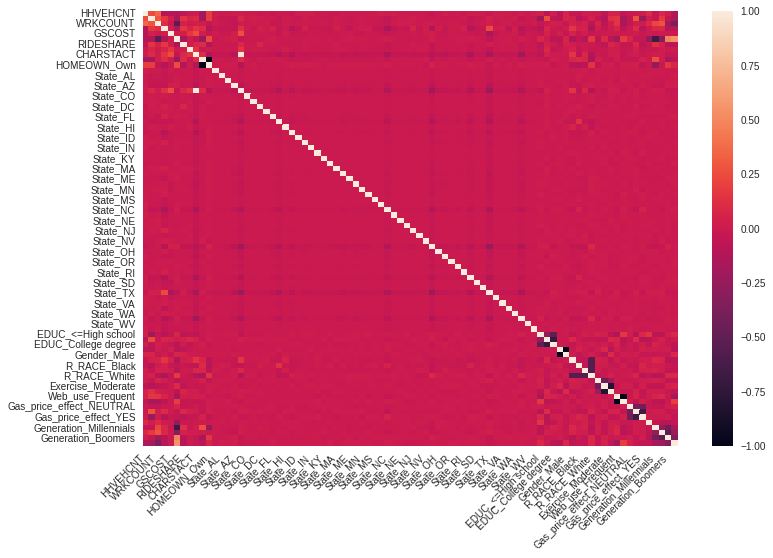

In [ ]:
#High level heat map to display correlation
plt.figure(figsize = (12,8))
corrplot = sns.heatmap(ohe_final_data.corr())
corrplot.set_xticklabels(corrplot.get_xticklabels(), rotation = 45, horizontalalignment = 'right') #For X axis labels
plt.show()

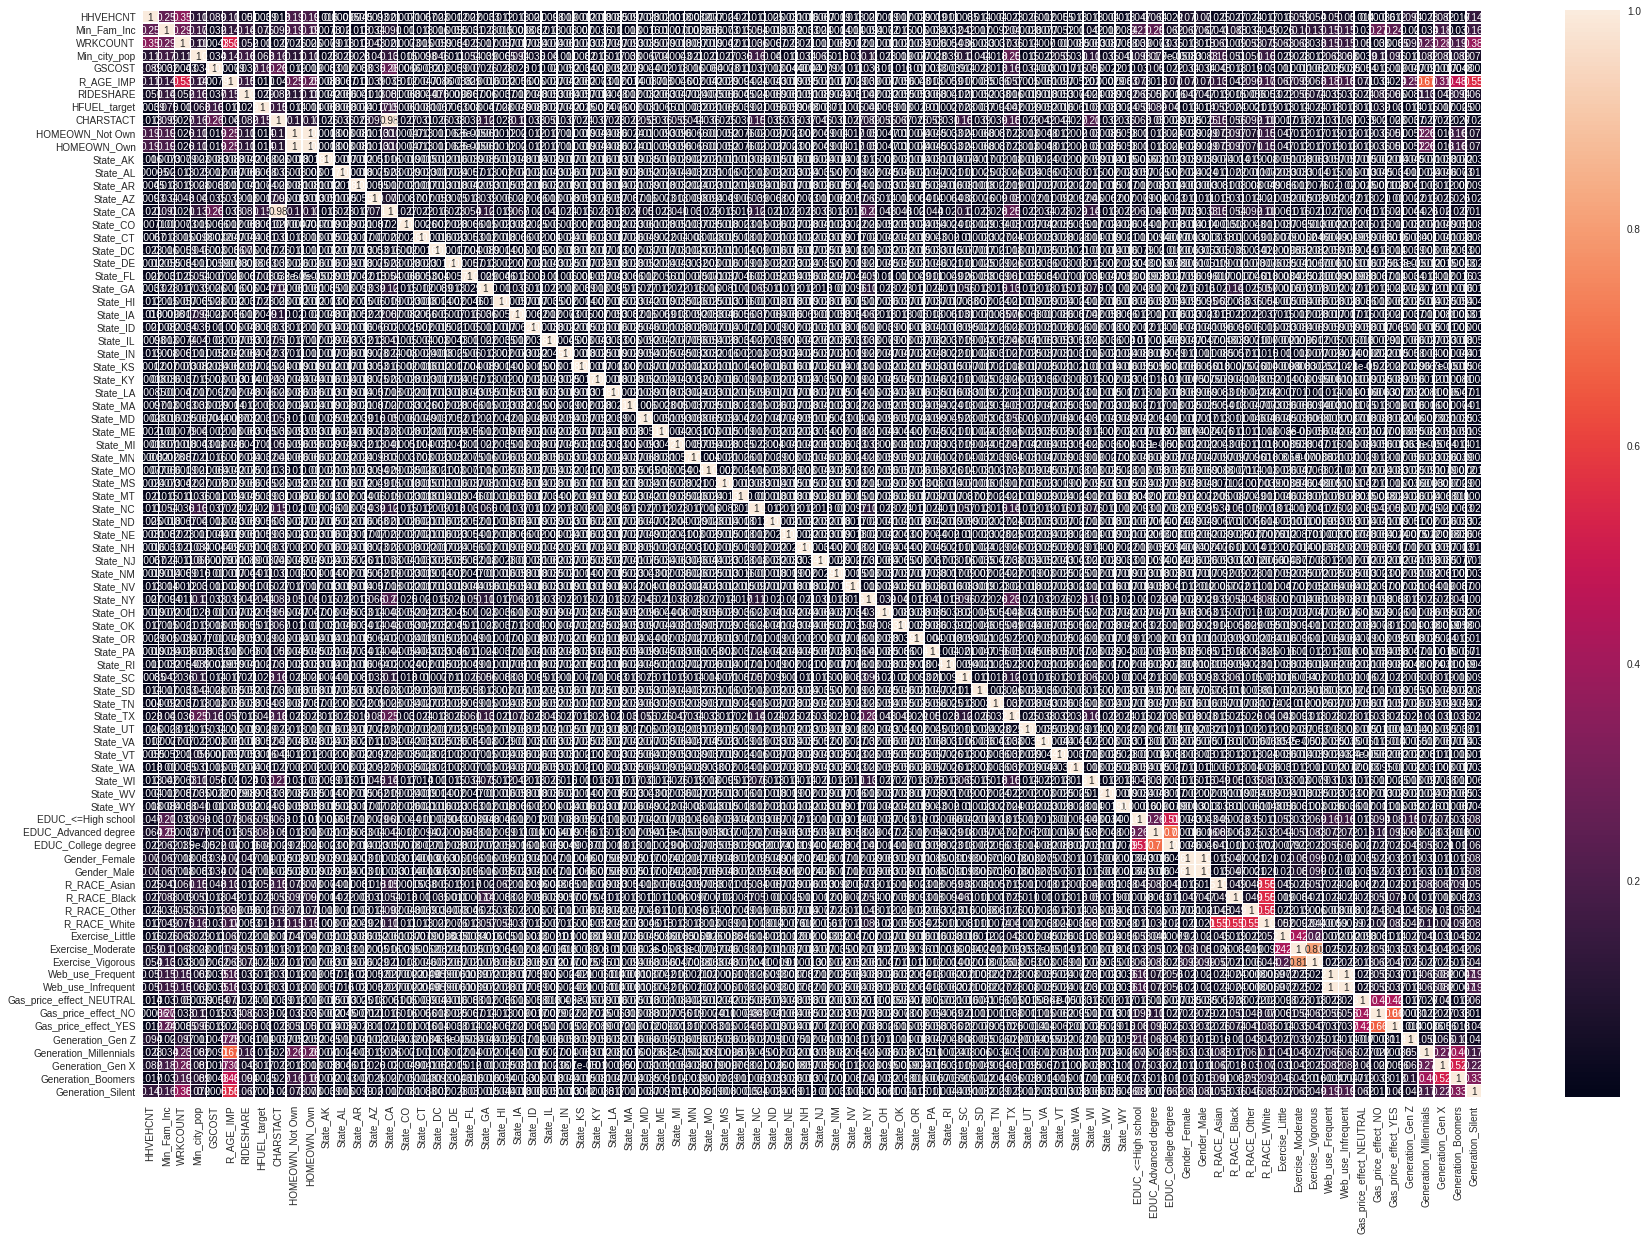

In [ ]:
# OHE Heat Map
corr_matrix_ohe = ohe_final_data.corr().abs()
fig, ax = plt.subplots(figsize=(30,20)) 
sns.heatmap(corr_matrix_ohe, annot = True, linewidths = 0.5, ax=ax)

Proportions of different variables by outcome of interest 


Text(0.5, 1.0, 'Boxplot of EV adoption vs. Age')

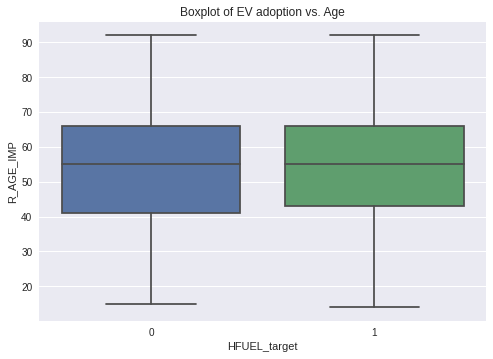

In [ ]:
#Boxplot EV adoption vs. age: 
sns.boxplot(x = "HFUEL_target", y='R_AGE_IMP', data = final_data)
plt.title("Boxplot of EV adoption vs. Age")

Text(0.5, 1.0, 'Boxplot of EV adoption vs. count of household vehicle')

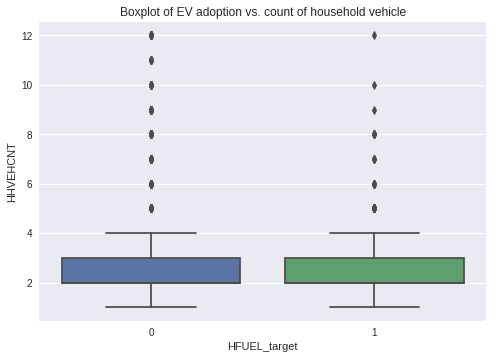

In [ ]:
#Boxplot EV adoption vs. count of household vehicle:
sns.boxplot(x = "HFUEL_target", y='HHVEHCNT', data = final_data)
plt.title("Boxplot of EV adoption vs. count of household vehicle")

Text(0.5, 1.0, 'Boxplot of EV adoption vs. number of workers in household')

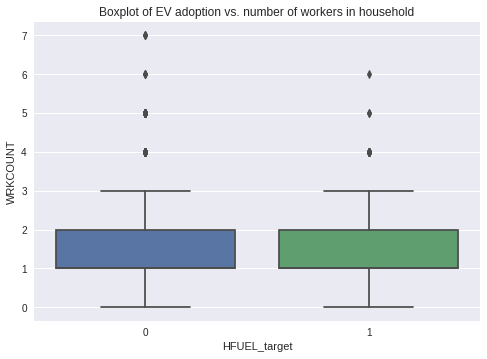

In [ ]:
#Boxplot EV adoption vs. number of workers in household:
sns.boxplot(x = "HFUEL_target", y='WRKCOUNT', data = final_data)
plt.title("Boxplot of EV adoption vs. number of workers in household")

Text(0.5, 1.0, 'Boxplot of EV adoption vs. fuel cost in US')

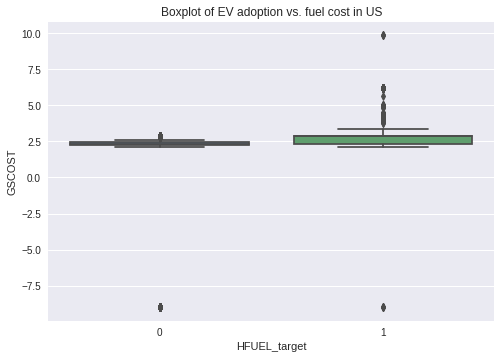

In [ ]:
#Boxplot EV adoption vs. fuel cost in US:
sns.boxplot(x = "HFUEL_target", y='GSCOST', data = final_data)
plt.title("Boxplot of EV adoption vs. fuel cost in US")

Text(0.5, 1.0, 'Boxplot of EV adoption vs. count of ride share')

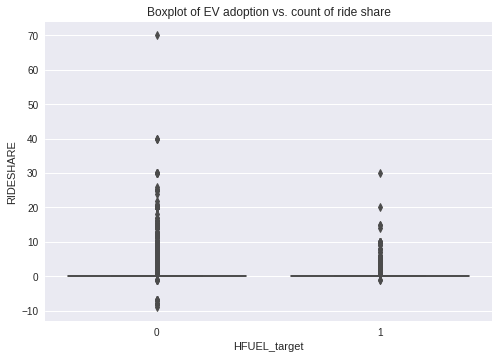

In [ ]:
#Boxplot EV adoption vs. count of ride share:
sns.boxplot(x = "HFUEL_target", y='RIDESHARE', data = final_data)
plt.title("Boxplot of EV adoption vs. count of ride share")

Perform chi-square test to test for any significance difference between variables and the outcome 


scipy.stats.chi2_contingency, from Scipy:
<br>
"Chi-square test of independence of variables in a contingency table"
In this test you are testing if there is there is relationship between two or more variable. This is called chi-square test for independence, also called Pearson's chi-square test or the chi-square test of association. In this test you are testing the association between two or more variable. The null hupothesis, in your example, is "there is no effect of group in choosing the equipment to use".
<br>
In scipy.stats.chisquare from Scipy
<br>
"The chi square test tests the null hypothesis that the categorical data has the given frequencies."
Here you are comparing if there is difference between an observation and an expected frequency. So, the null hupothesis, is that "there isn't any difference between observed and the expected". Here, the test is used to compare the observed sample distribution with the expected probability distribution. This is named Chi-Square goodness of fit test
<br>
let alpha=0.05 (significance level)<br>
A small p (≤ 0.05), reject the null hypothesis. This is strong evidence that the null hypothesis is invalid.
A large p (> 0.05) means the alternate hypothesis is weak, so you do not reject the null.

In [ ]:
data_crosstab = pd.crosstab(final_data['HFUEL_target'],
                            final_data['HOMEOWN'],
                           margins=True, margins_name="Total")

In [ ]:
data_crosstab

HOMEOWN,Not Own,Own,Total
HFUEL_target,,,
0,4608,26313,30921
1,157,1112,1269
Total,4765,27425,32190


In [ ]:
p_vals=[]
var_names=[]
for column in final_data.columns:
    data_crosstab = pd.crosstab(final_data['HFUEL_target'],
                            final_data[column],
                           margins=True, margins_name="Total")
    c, p, dof, expected = stats.chi2_contingency(data_crosstab) 
    p_vals.append(p)
    var_names.append(column)
Chi2_table=pd.DataFrame({'var_names':var_names,'p_vals':p_vals})
alpha=0.05
Chi2_table['sig']=Chi2_table['p_vals'].apply(lambda x: 'dependent' if x<=alpha else 'independent')

#df['equal_or_lower_than_4?'] = df['set_of_numbers'].apply(lambda x: 'True' if x <= 4 else 'False')
Chi2_table

,var_names,p_vals,sig
0,HOMEOWN,1.854364e-01,independent
1,HHVEHCNT,3.267084e-01,independent
2,Min_Fam_Inc,7.583098e-28,dependent
3,State,3.122610e-116,dependent
4,WRKCOUNT,7.101440e-01,independent
5,Min_city_pop,9.797532e-26,dependent
6,GSCOST,0.000000e+00,dependent
7,R_AGE_IMP,9.890482e-01,independent
8,EDUC,2.367957e-59,dependent
9,Gender,1.795291e-01,independent


Independent t-test

In [ ]:
#p_vals=[]
#var_names=[]
#for column in final_data.columns:
 # a=np.array(final_data[final_data['HFUEL_target']==1][column])
  #b=np.array(final_data[final_data['HFUEL_target']==0][column])
  #statistic, pvalue=stats.ttest_ind(a,b)
  #p_vals.append(pvalue)
  #var_names.append(column)
#ttest_table=pd.DataFrame({'var_names':var_names,'p_vals':p_vals})
#alpha=0.05
#ttest_table['sig']=ttest_table['p_vals'].apply(lambda x: 'dependent' if x<=alpha else 'independent')
#ttest_table

### Data Segmentation for ML
Top 7 states for EV Penetration: <br>
Hawaii, HI <br>
California, CA <br>
New Mexico, NM <br>
District of Columbia, DC <br>
Connecticut, CT <br>
New Hampshire, NH <br>
Massachusetts, MA (tied)


In [ ]:
final_data.columns

Index(['HOMEOWN', 'HHVEHCNT', 'Min_Fam_Inc', 'State', 'WRKCOUNT',
       'Min_city_pop', 'GSCOST', 'R_AGE_IMP', 'EDUC', 'Gender', 'R_RACE',
       'RIDESHARE', 'Exercise', 'Web_use', 'Gas_price_effect', 'HFUEL_target',
       'CHARSTACT', 'Generation'],
      dtype='object')

In [ ]:
# Labeling the Data in High EV states
high_ev = ['DC', 'CA', 'HI', 'NM', 'CT']

#Adding a column to indicate if a person is in a high EV penetration state
ml_data=final_data.copy()
ml_data['high_ev_state'] = np.where(ml_data['State'].isin(high_ev),1,0)

# Segmenting the Data
high_ev_dat = final_data[final_data['State'].isin(high_ev)]
low_ev_dat = final_data[~final_data['State'].isin(high_ev)]

#drop state and age columns
ml_data.drop(['State', 'R_AGE_IMP'], axis = 1, inplace = True)
high_ev_dat.drop(['State', 'R_AGE_IMP'], axis = 1, inplace = True)
low_ev_dat.drop(['State', 'R_AGE_IMP'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#LabelEncoder assigns numbers to each string category
#pd.get_dummies creates new column (one hot encoded) for each category
#transform the home ownership column
#high_ev_dat['HOMEOWN'] = LabelEncoder().fit_transform(high_ev_dat['HOMEOWN'])
#low_ev_dat['HOMEOWN'] = LabelEncoder().fit_transform(low_ev_dat['HOMEOWN'])
#high_ev_dat['R_RACE'] = LabelEncoder().fit_transform(high_ev_dat['R_RACE'])
#low_ev_dat['R_RACE'] = LabelEncoder().fit_transform(low_ev_dat['R_RACE'])

In [ ]:
# Overall Ev Penetration
100*len(ml_data[ml_data['HFUEL_target'] == 1])/ml_data['HFUEL_target'].value_counts().sum()

3.9422180801491145

In [ ]:
# High Ev Penetration
100*len(high_ev_dat[high_ev_dat['HFUEL_target'] == 1])/high_ev_dat['HFUEL_target'].value_counts().sum()

10.21523178807947

In [ ]:
# Low EV Penetration
100*len(low_ev_dat[low_ev_dat['HFUEL_target'] == 1])/low_ev_dat['HFUEL_target'].value_counts().sum()

2.4933078393881454

In [ ]:
# Segmented One Hot Encoded Data without state
ohe_vars=['HOMEOWN','EDUC', 'Gender', 'R_RACE','Exercise', 'Web_use', 'Gas_price_effect','Generation']

#One hot encode
ohe_ml_data = pd.get_dummies(ml_data, columns=ohe_vars,dtype=int)
high_ev_dat_ohe = pd.get_dummies(high_ev_dat, columns=ohe_vars,dtype=int)
low_ev_dat_ohe = pd.get_dummies(low_ev_dat, columns=ohe_vars,dtype=int)

#drop one of each of the binary category columns
bin_vars=['HOMEOWN_Not Own', 'Gender_Female','Web_use_Infrequent']
ohe_ml_data.drop(bin_vars, axis = 1, inplace = True)
high_ev_dat_ohe.drop(bin_vars, axis = 1, inplace = True)
low_ev_dat_ohe.drop(bin_vars, axis = 1, inplace = True)

In [ ]:
ohe_ml_data.columns

Index(['HHVEHCNT', 'Min_Fam_Inc', 'WRKCOUNT', 'Min_city_pop', 'GSCOST',
       'RIDESHARE', 'HFUEL_target', 'CHARSTACT', 'high_ev_state',
       'HOMEOWN_Own', 'EDUC_<=High school', 'EDUC_Advanced degree',
       'EDUC_College degree', 'Gender_Male', 'R_RACE_Asian', 'R_RACE_Black',
       'R_RACE_Other', 'R_RACE_White', 'Exercise_Little', 'Exercise_Moderate',
       'Exercise_Vigorous', 'Web_use_Frequent', 'Gas_price_effect_NEUTRAL',
       'Gas_price_effect_NO', 'Gas_price_effect_YES', 'Generation_Gen Z',
       'Generation_Millennials', 'Generation_Gen X', 'Generation_Boomers',
       'Generation_Silent'],
      dtype='object')

### Demographic variables
'HHVEHCNT',
'Min_Fam_Inc', 
'WRKCOUNT', 
'RIDESHARE',
'HOMEOWN_Own', 
'EDUC_<=High school', 
'EDUC_Advanced degree',
'EDUC_College degree', 
'Gender_Male', 
'R_RACE_Asian', 
'R_RACE_Black',
'R_RACE_Other', 
'R_RACE_White', 
'Exercise_Little', 
'Exercise_Moderate',
'Exercise_Vigorous', 
'Web_use_Frequent', 
'Gas_price_effect_NEUTRAL',
'Gas_price_effect_NO', 
'Gas_price_effect_YES', 
'Generation_Gen Z',
'Generation_Millennials', 
'Generation_Gen X', 
'Generation_Boomers',
'Generation_Silent'
       
### Geographic/policy variables
'Min_city_pop', 
'GSCOST',
'high_ev_state'

# Predicting without segmentation
Drop the 'state' and 'high_ev_state' identifiers and see if we can predict without knowing the location of the person <br>
Baseline model

In [ ]:
ohe_ml_data.drop(['high_ev_state', 'HOMEOWN_Own', 'WRKCOUNT', 'RIDESHARE'], axis = 1, inplace = True)
len(ohe_ml_data.columns)

26

In [ ]:
#Separate the features from the target variable
X_unba=ohe_ml_data.drop(['HFUEL_target'], axis = 1)
y_unba=ohe_ml_data['HFUEL_target']

#Scale the feature data
scaler = MinMaxScaler()
X = scaler.fit_transform(X_unba)
y = y_unba

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# models to fit

models = [LogisticRegression(max_iter=500),svm.LinearSVC(),RandomForestClassifier(),DecisionTreeClassifier(), GaussianNB()] 
model_names = ['LogisticRegression()','svm.LinearSVC()','RandomForestClassifier()','DecisionTreeClassifier()', 'GaussianNB()'] 

f1_macro=[]
accuracy=[]
precision=[]
recall=[]
auc=[]
cm=[]
for model in models:
    clf=model
    over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under)]
    # define pipeline
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_resample, y_resample = pipeline.fit_resample(X_train, y_train)
    # fit the model
    clf.fit(X_resample, y_resample)
    y_pred = clf.predict(X_test)
    # look at metrics
    f1_macro.append(f1_score(y_test, y_pred, average='macro'))
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='weighted'))
    recall.append(recall_score(y_test, y_pred, average='weighted'))
    auc.append(roc_auc_score(y_test, y_pred))
    cm.append(confusion_matrix(y_test, y_pred))

unb_test_metric_df=pd.DataFrame({'model': model_names, 'f1_macro':f1_macro,'Accuracy': accuracy, 'Precision': precision,'Recall': recall, 'AUC':auc})
unb_test_metric_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

,model,f1_macro,Accuracy,Precision,Recall,AUC
0,LogisticRegression(),0.587029,0.902247,0.942573,0.902247,0.648153
1,svm.LinearSVC(),0.597000,0.909806,0.943500,0.909806,0.653381
2,RandomForestClassifier(),0.631035,0.959097,0.948563,0.959097,0.599860
3,DecisionTreeClassifier(),0.583584,0.923268,0.939388,0.923268,0.605885
4,GaussianNB(),0.350298,0.449001,0.944129,0.449001,0.604533


### Data Imbalance treatment
Synthetic Minority Oversampling Technique

In [ ]:
#Separate the features from the target variable
X_all=ohe_ml_data.drop(['HFUEL_target'], axis = 1)
y_all=ohe_ml_data['HFUEL_target']

#Scale the feature data
scaler = MinMaxScaler()
X = scaler.fit_transform(X_all)
y = y_all

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

y_test_all =y_test

In [ ]:
# summarize class distribution
y=[y_all,y_train, y_test]
for data in y:
    counter = Counter(data)
    print(counter)

Counter({0: 30921, 1: 1269})
Counter({0: 21634, 1: 899})
Counter({0: 9287, 1: 370})


### Use SMOTE to over and under sample for a more balanced dataset
E.g. for a sample of 10,000:100: first oversample the minority class to have 10 percent the number of examples of the majority class (e.g. about 1,000), then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class (e.g. about 2,000).

In [ ]:
# values to evaluate
# default k_neighbors=5
# (over,under)
# best over sampling_strategy=0.4 (0.1,0.1), (0.2,0.2), (0.3,0.6, 0.789), (0.4,0.5, 0.79),(0.5,0.5, 0.79)
# best under sampling_strategy=0.4

#k_values = [1, 2, 3, 4, 5, 6, 7]
k_values = [0.4,0.5,0.6,0.7,0.8,0.9]
#k_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9]

for k in k_values:
    # define pipeline
    model = LogisticRegression()
    #model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
    under = RandomUnderSampler(sampling_strategy=k)
    steps = [('over', over), ('under', under)]
    # define pipeline
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_resample, y_resample = pipeline.fit_resample(X_train, y_train)
    # evaluate pipeline using cross validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # look at AUC score
    scores = cross_val_score(model, X_resample, y_resample, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%.1f, Mean ROC AUC: %.3f' % (k, score))
    counter = Counter(y_resample)
    print(counter)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


> k=0.4, Mean ROC AUC: 0.785
Counter({0: 21632, 1: 8653})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


> k=0.5, Mean ROC AUC: 0.786
Counter({0: 17306, 1: 8653})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


> k=0.6, Mean ROC AUC: 0.785
Counter({0: 14421, 1: 8653})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


> k=0.7, Mean ROC AUC: 0.778
Counter({0: 12361, 1: 8653})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


> k=0.8, Mean ROC AUC: 0.776
Counter({0: 10816, 1: 8653})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


> k=0.9, Mean ROC AUC: 0.782
Counter({0: 9614, 1: 8653})


Find optimal sampling strategy for basic Logistic Regression model <br>
Solution <br>
best over sampling_strategy=0.4 <br>
best under sampling_strategy=0.5 <br>
k_neighbors=5 (default)

### Logistic Regression
models = [LogisticRegression(),svm.SVC(kernel='linear', probability=True),RandomForestClassifier(),DecisionTreeClassifier(), GaussianNB()]


In [ ]:
# models to evaluate
# default k_neighbors=5
# sampling_strategy: (over,under) = (0.4,0.5)

model = LogisticRegression()
over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]
# define pipeline
pipeline = Pipeline(steps=steps)
# transform the dataset
X_resample, y_resample = pipeline.fit_resample(X_train, y_train)
# evaluate pipeline using cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# look at AUC score
scores = cross_val_score(model, X_resample, y_resample, scoring='roc_auc', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('> model: LogisticRegression(), Mean ROC AUC: %.3f' % (score))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


> model: LogisticRegression(), Mean ROC AUC: 0.784


### All models

F1 Score,Accuracy ,Precision,Recall,AUC <br>
F1 Score: 'f1_macro' <br>
'macro': does not take label imbalance into account.
'weighted': alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
Accuracy: 'accuracy'
Precision: 'precision'
Recall: 'recall'
AUC:‘roc_auc’

In [ ]:
# models to evaluate
# default k_neighbors=5
# sampling_strategy: (over,under) = (0.4,0.5)

models = [LogisticRegression(max_iter=500),svm.LinearSVC(),RandomForestClassifier(),DecisionTreeClassifier(), GaussianNB()] 
model_names = ['LogisticRegression()','svm.LinearSVC()','RandomForestClassifier()','DecisionTreeClassifier()', 'GaussianNB()'] 

f1_macro=[]
accuracy=[]
precision=[]
recall=[]
auc=[]
for model in models:
    over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under)]
    # define pipeline
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_resample, y_resample = pipeline.fit_resample(X_train, y_train)
    # evaluate pipeline using cross validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # look at metrics
    f1_macro.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='f1_macro', cv=cv, n_jobs=-1)))
    accuracy.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='accuracy', cv=cv, n_jobs=-1)))
    precision.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='precision', cv=cv, n_jobs=-1)))
    recall.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='recall', cv=cv, n_jobs=-1)))
    auc.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='roc_auc', cv=cv, n_jobs=-1)))

metric_df=pd.DataFrame({'model': model_names, 'f1_macro':f1_macro,'Accuracy': accuracy, 'Precision': precision,'Recall': recall, 'AUC':auc})
metric_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

,model,f1_macro,Accuracy,Precision,Recall,AUC
0,LogisticRegression(),0.692679,0.761084,0.742290,0.434145,0.783096
1,svm.LinearSVC(),0.689523,0.761470,0.755751,0.420434,0.786002
2,RandomForestClassifier(),0.957313,0.962620,0.972554,0.914672,0.981539
3,DecisionTreeClassifier(),0.925610,0.933202,0.896082,0.906428,0.929898
4,GaussianNB(),0.568664,0.568769,0.425627,0.839171,0.735219


In [ ]:
# models to fit

models = [LogisticRegression(),svm.LinearSVC(),RandomForestClassifier(),DecisionTreeClassifier(), GaussianNB()] 
model_names = ['LogisticRegression()','svm.LinearSVC()','RandomForestClassifier()','DecisionTreeClassifier()', 'GaussianNB()'] 

f1_macro=[]
accuracy=[]
precision=[]
recall=[]
auc=[]
cm=[]
for model in models:
    over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under)]
    # define pipeline
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_resample, y_resample = pipeline.fit_resample(X_train, y_train)
    # fit the model
    model.fit(X_resample, y_resample)
    y_pred = model.predict(X_test)
    # look at metrics
    f1_macro.append(f1_score(y_test, y_pred, average='macro'))
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='weighted'))
    recall.append(recall_score(y_test, y_pred, average='weighted'))
    auc.append(roc_auc_score(y_test, y_pred))
    cm.append(confusion_matrix(y_test, y_pred))

test_metric_df=pd.DataFrame({'model': model_names, 'f1_macro':f1_macro,'Accuracy': accuracy, 'Precision': precision,'Recall': recall, 'AUC':auc})
test_metric_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGI

,model,f1_macro,Accuracy,Precision,Recall,AUC
0,LogisticRegression(),0.586948,0.901108,0.942729,0.901108,0.650156
1,svm.LinearSVC(),0.593305,0.908460,0.942948,0.908460,0.648789
2,RandomForestClassifier(),0.632756,0.959718,0.949148,0.959718,0.600183
3,DecisionTreeClassifier(),0.575324,0.921508,0.938131,0.921508,0.595887
4,GaussianNB(),0.359966,0.466397,0.944292,0.466397,0.609686


### Random forest is best model, optimize for all data below:

In [ ]:
# default k_neighbors=5
# sampling_strategy: (over,under) = (0.4,0.5)

#Fit Random forest model on balanced data
over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]
# define pipeline
pipeline = Pipeline(steps=steps)
# transform the dataset
X_resample, y_resample = pipeline.fit_resample(X_train, y_train)

# grid search
from sklearn.model_selection import RandomizedSearchCV

hyper_params={
    
    'max_depth':range(3,20),
    'max_features':range(3,37),
    'min_samples_leaf': range(20,400,50),
    'n_estimators':range(10,101,10)
}

rf_rcv=RandomizedSearchCV(estimator=RandomForestClassifier(),
                          param_distributions=hyper_params,
                          verbose=1,
                          cv=5,
                          return_train_score=True,
                          n_jobs=-1, 
                          n_iter=50)
rf_rcv.fit(X_resample, y_resample)
rf_rcv.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features=21,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# feature importance
#high_ev_dat_ohe_train=high_ev_dat_ohe.drop(columns=label_var)

rf_feature_importance=pd.DataFrame(rf_rcv.best_estimator_.feature_importances_,index=X_all.columns).reset_index()
rf_feature_importance.columns=['feature','importance']
rf_feature_importance.sort_values(ascending=False, by='importance').head(10)
#y_pred_rf = rf_rcv.predict(X_test)

,feature,importance
3,GSCOST,0.424767
4,CHARSTACT,0.301393
2,Min_city_pop,0.104643
0,HHVEHCNT,0.063752
1,Min_Fam_Inc,0.050942
6,EDUC_Advanced degree,0.013409
8,Gender_Male,0.009958
14,Exercise_Moderate,0.004137
23,Generation_Boomers,0.003764
19,Gas_price_effect_YES,0.003449


In [ ]:
y_pred_all_rf = rf_rcv.predict(X_test)

### Predicting on ENTIRE dataset

In [ ]:
y_pred = rf_rcv.predict(X)

In [ ]:
X.shape

(32190, 25)

In [ ]:
y_pred.sum()

436

In [ ]:
y_all.sum()

1269

# Predicting with segmentation in high and low (everything else) EV adoption states
Separate the data and see if we can predict each person in each regiong<br>
2 segmented models
### High EV penetration states

In [ ]:
#Separate the features from the target variable
X_high=high_ev_dat_ohe.drop(['HFUEL_target', 'HOMEOWN_Own', 'WRKCOUNT', 'RIDESHARE'], axis = 1) #low_ev_dat_ohe
y_high=high_ev_dat_ohe['HFUEL_target']

#Scale the feature data
scaler = MinMaxScaler()
X = scaler.fit_transform(X_high)
y = y_high

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

y_test_high =y_test

In [ ]:
# summarize class distribution
y=[y_high,y_train, y_test]
for data in y:
    counter = Counter(data)
    print(counter)

Counter({0: 5423, 1: 617})
Counter({0: 3808, 1: 420})
Counter({0: 1615, 1: 197})


In [ ]:
# models to evaluate
# default k_neighbors=5
# sampling_strategy: (over,under) = (0.4,0.5)

models = [LogisticRegression(),svm.LinearSVC(),RandomForestClassifier(),DecisionTreeClassifier(), GaussianNB()] 
model_names = ['LogisticRegression()','svm.LinearSVC()','RandomForestClassifier()','DecisionTreeClassifier()', 'GaussianNB()'] 

f1_macro=[]
accuracy=[]
precision=[]
recall=[]
auc=[]
for model in models:
    over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under)]
    # define pipeline
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_resample, y_resample = pipeline.fit_resample(X_train, y_train)
    # evaluate pipeline using cross validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # look at metrics
    f1_macro.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='f1_macro', cv=cv, n_jobs=-1)))
    accuracy.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='accuracy', cv=cv, n_jobs=-1)))
    precision.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='precision', cv=cv, n_jobs=-1)))
    recall.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='recall', cv=cv, n_jobs=-1)))
    auc.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='roc_auc', cv=cv, n_jobs=-1)))

high_metric_df=pd.DataFrame({'model': model_names, 'f1_macro':f1_macro,'Accuracy': accuracy, 'Precision': precision,'Recall': recall, 'AUC':auc})
high_metric_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

,model,f1_macro,Accuracy,Precision,Recall,AUC
0,LogisticRegression(),0.657711,0.757496,0.856376,0.328083,0.756903
1,svm.LinearSVC(),0.659770,0.766834,0.968767,0.310982,0.762004
2,RandomForestClassifier(),0.895114,0.909316,0.929562,0.789217,0.932309
3,DecisionTreeClassifier(),0.842569,0.863207,0.787684,0.798418,0.851773
4,GaussianNB(),0.563746,0.564747,0.419610,0.791866,0.720737


In [ ]:
# models to fit

models = [LogisticRegression(),svm.LinearSVC(),RandomForestClassifier(),DecisionTreeClassifier(), GaussianNB()] 
model_names = ['LogisticRegression()','svm.LinearSVC()','RandomForestClassifier()','DecisionTreeClassifier()', 'GaussianNB()'] 

f1_macro=[]
accuracy=[]
precision=[]
recall=[]
auc=[]
cm=[]
for model in models:
    over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under)]
    # define pipeline
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_resample, y_resample = pipeline.fit_resample(X_train, y_train)
    # fit the model
    model.fit(X_resample, y_resample)
    y_pred = model.predict(X_test)
    # look at metrics
    f1_macro.append(f1_score(y_test, y_pred, average='macro'))
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='weighted'))
    recall.append(recall_score(y_test, y_pred, average='weighted'))
    auc.append(roc_auc_score(y_test, y_pred))
    cm.append(confusion_matrix(y_test, y_pred))

high_test_metric_df=pd.DataFrame({'model': model_names, 'f1_macro':f1_macro,'Accuracy': accuracy, 'Precision': precision,'Recall': recall, 'AUC':auc})
high_test_metric_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

,model,f1_macro,Accuracy,Precision,Recall,AUC
0,LogisticRegression(),0.655554,0.891280,0.872593,0.891280,0.629251
1,svm.LinearSVC(),0.668085,0.900110,0.881973,0.900110,0.634205
2,RandomForestClassifier(),0.643064,0.889625,0.868780,0.889625,0.617180
3,DecisionTreeClassifier(),0.598836,0.833885,0.844883,0.833885,0.605967
4,GaussianNB(),0.432380,0.493377,0.854294,0.493377,0.611051


### Random forest is best model, optimize for all data below:

In [ ]:
# default k_neighbors=5
# sampling_strategy: (over,under) = (0.4,0.5)

#Fit Random forest model on balanced data
over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]
# define pipeline
pipeline = Pipeline(steps=steps)
# transform the dataset
X_resample, y_resample = pipeline.fit_resample(X_train, y_train)

# grid search
from sklearn.model_selection import RandomizedSearchCV

hyper_params={
    
    'max_depth':range(3,20),
    'max_features':range(3,37),
    'min_samples_leaf': range(20,400,50),
    'n_estimators':range(10,101,10)
}

rf_rcv=RandomizedSearchCV(estimator=RandomForestClassifier(),
                          param_distributions=hyper_params,
                          verbose=1,
                          cv=5,
                          return_train_score=True,
                          n_jobs=-1, 
                          n_iter=50)
rf_rcv.fit(X_resample, y_resample)
rf_rcv.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 247 out of 250 | elapsed:   28.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   28.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=19,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# feature importance
#high_ev_dat_ohe_train=high_ev_dat_ohe.drop(columns=label_var)

rf_feature_importance=pd.DataFrame(rf_rcv.best_estimator_.feature_importances_,index=X_high.columns).reset_index()
rf_feature_importance.columns=['feature','importance']
rf_feature_importance.sort_values(ascending=False, by='importance').head(10)
#y_pred_rf = rf_rcv.predict(X_test)

,feature,importance
3,GSCOST,0.434706
1,Min_Fam_Inc,0.141201
0,HHVEHCNT,0.106082
2,Min_city_pop,0.104972
8,Gender_Male,0.066640
6,EDUC_Advanced degree,0.052289
14,Exercise_Moderate,0.015391
21,Generation_Millennials,0.010850
23,Generation_Boomers,0.010169
18,Gas_price_effect_NO,0.009055


In [ ]:
y_pred_high_rf = rf_rcv.predict(X_test)

### Low EV penetration states

In [ ]:
#Separate the features from the target variable
X_low=low_ev_dat_ohe.drop(['HFUEL_target', 'HOMEOWN_Own', 'WRKCOUNT', 'RIDESHARE'], axis = 1) #low_ev_dat_ohe
y_low=low_ev_dat_ohe['HFUEL_target']

#Scale the feature data
scaler = MinMaxScaler()
X = scaler.fit_transform(X_low)
y = y_low

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_test_low =y_test

In [ ]:
# summarize class distribution
y=[y_low,y_train, y_test]
for data in y:
    counter = Counter(data)
    print(counter)

Counter({0: 25498, 1: 652})
Counter({0: 17834, 1: 471})
Counter({0: 7664, 1: 181})


In [ ]:
# models to evaluate
# default k_neighbors=5
# sampling_strategy: (over,under) = (0.4,0.5)

models = [LogisticRegression(),svm.LinearSVC(),RandomForestClassifier(),DecisionTreeClassifier(), GaussianNB()] 
model_names = ['LogisticRegression()','svm.LinearSVC()','RandomForestClassifier()','DecisionTreeClassifier()', 'GaussianNB()'] 

f1_macro=[]
accuracy=[]
precision=[]
recall=[]
auc=[]
for model in models:
    over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under)]
    # define pipeline
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_resample, y_resample = pipeline.fit_resample(X_train, y_train)
    # evaluate pipeline using cross validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # look at metrics
    f1_macro.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='f1_macro', cv=cv, n_jobs=-1)))
    accuracy.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='accuracy', cv=cv, n_jobs=-1)))
    precision.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='precision', cv=cv, n_jobs=-1)))
    recall.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='recall', cv=cv, n_jobs=-1)))
    auc.append(np.mean(cross_val_score(model, X_resample, y_resample, scoring='roc_auc', cv=cv, n_jobs=-1)))

high_metric_df=pd.DataFrame({'model': model_names, 'f1_macro':f1_macro,'Accuracy': accuracy, 'Precision': precision,'Recall': recall, 'AUC':auc})
high_metric_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

,model,f1_macro,Accuracy,Precision,Recall,AUC
0,LogisticRegression(),0.617293,0.722604,0.697032,0.297163,0.727699
1,svm.LinearSVC(),0.613750,0.725533,0.728656,0.281600,0.730576
2,RandomForestClassifier(),0.972468,0.976307,0.984924,0.941913,0.987860
3,DecisionTreeClassifier(),0.943180,0.949390,0.917070,0.933081,0.946337
4,GaussianNB(),0.525158,0.526022,0.400649,0.850225,0.683156


In [ ]:
# models to fit

models = [LogisticRegression(),svm.LinearSVC(),RandomForestClassifier(),DecisionTreeClassifier(), GaussianNB()] 
model_names = ['LogisticRegression()','svm.LinearSVC()','RandomForestClassifier()','DecisionTreeClassifier()', 'GaussianNB()'] 

f1_macro=[]
accuracy=[]
precision=[]
recall=[]
auc=[]
cm=[]
for model in models:
    over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under)]
    # define pipeline
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_resample, y_resample = pipeline.fit_resample(X_train, y_train)
    # fit the model
    model.fit(X_resample, y_resample)
    y_pred = model.predict(X_test)
    # look at metrics
    f1_macro.append(f1_score(y_test, y_pred, average='macro'))
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='weighted'))
    recall.append(recall_score(y_test, y_pred, average='weighted'))
    auc.append(roc_auc_score(y_test, y_pred))
    cm.append(confusion_matrix(y_test, y_pred))

low_test_metric_df=pd.DataFrame({'model': model_names, 'f1_macro':f1_macro,'Accuracy': accuracy, 'Precision': precision,'Recall': recall, 'AUC':auc})
low_test_metric_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGI

,model,f1_macro,Accuracy,Precision,Recall,AUC
0,LogisticRegression(),0.528862,0.909242,0.959722,0.909242,0.578640
1,svm.LinearSVC(),0.540061,0.924793,0.960089,0.924793,0.581204
2,RandomForestClassifier(),0.595819,0.974251,0.965662,0.974251,0.568757
3,DecisionTreeClassifier(),0.553465,0.943403,0.960366,0.943403,0.577244
4,GaussianNB(),0.282382,0.359337,0.957600,0.359337,0.521061


### Random forest is best model, optimize for all data below:

In [ ]:
# default k_neighbors=5
# sampling_strategy: (over,under) = (0.4,0.5)

#Fit Random forest model on balanced data
over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]
# define pipeline
pipeline = Pipeline(steps=steps)
# transform the dataset
X_resample, y_resample = pipeline.fit_resample(X_train, y_train)

# grid search
from sklearn.model_selection import RandomizedSearchCV

hyper_params={
    
    'max_depth':range(3,20),
    'max_features':range(3,37),
    'min_samples_leaf': range(20,400,50),
    'n_estimators':range(10,101,10)
}

rf_rcv=RandomizedSearchCV(estimator=RandomForestClassifier(),
                          param_distributions=hyper_params,
                          verbose=1,
                          cv=5,
                          return_train_score=True,
                          n_jobs=-1, 
                          n_iter=50)
rf_rcv.fit(X_resample, y_resample)
rf_rcv.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.6min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# feature importance
#high_ev_dat_ohe_train=high_ev_dat_ohe.drop(columns=label_var)

rf_feature_importance=pd.DataFrame(rf_rcv.best_estimator_.feature_importances_,index=X_all.columns).reset_index()
rf_feature_importance.columns=['feature','importance']
rf_feature_importance.sort_values(ascending=False, by='importance').head(10)
#y_pred_rf = rf_rcv.predict(X_test)

,feature,importance
1,Min_Fam_Inc,0.326288
3,GSCOST,0.255085
4,CHARSTACT,0.138644
0,HHVEHCNT,0.136545
2,Min_city_pop,0.077294
8,Gender_Male,0.013363
6,EDUC_Advanced degree,0.010059
24,Generation_Silent,0.006330
23,Generation_Boomers,0.004905
15,Exercise_Vigorous,0.004631


In [ ]:
y_pred_low_rf = rf_rcv.predict(X_test)

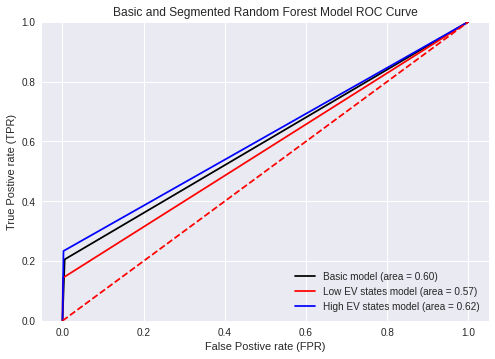

AUC on TEST for Basic NB: 0.600
AUC on TEST for Low EV states: 0.571
AUC on TEST for High EV states: 0.616


In [ ]:
# plot lines for model comparison
import sklearn.metrics
fpr, tpr, thr=sklearn.metrics.roc_curve(y_test_all, y_pred_all_rf)
fpr_l, tpr_l, thr_l=sklearn.metrics.roc_curve(y_test_low, y_pred_low_rf)
fpr_h, tpr_h, thr_h=sklearn.metrics.roc_curve(y_test_high,y_pred_high_rf)

plt.title('Basic and Segmented Random Forest Model ROC Curve')
plt.plot(fpr,tpr, color='black',label='Basic model (area = %0.2f)' % sklearn.metrics.roc_auc_score(y_test_all, y_pred_all_rf))
plt.plot(fpr_l,tpr_l, color='red',label='Low EV states model (area = %0.2f)' % sklearn.metrics.roc_auc_score(y_test_low, y_pred_low_rf))
plt.plot(fpr_h,tpr_h, color='blue',label='High EV states model (area = %0.2f)' % sklearn.metrics.roc_auc_score(y_test_high, y_pred_high_rf))
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR)");
plt.ylabel("True Postive rate (TPR)");
plt.legend(loc="lower right")
#plt.savefig('RF_ROC')
plt.show()

print("AUC on TEST for Basic NB: %.3f" % (sklearn.metrics.roc_auc_score(y_test_all, y_pred_all_rf))) 
print("AUC on TEST for Low EV states: %.3f" % (sklearn.metrics.roc_auc_score(y_test_low, y_pred_low_rf)))
print("AUC on TEST for High EV states: %.3f" % (sklearn.metrics.roc_auc_score(y_test_high,y_pred_high_rf)))



### Confusion Matrices

In [ ]:
cm_all=confusion_matrix(y_test_all, y_pred_all_rf)
cm_low=confusion_matrix(y_test_low, y_pred_low_rf)
cm_high=confusion_matrix(y_test_high,y_pred_high_rf)

for cm in [cm_all,cm_low,cm_high]:
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    print(cm_df)

Predicted     0   1
True               
0          9237  50
1           294  76
Predicted     0   1
True               
0          7656   8
1           155  26
Predicted     0   1
True               
0          1611   4
1           151  46


In [ ]:
#can also try standardscaler instead of min max
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()

#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Predicting on entire data state

In [ ]:
ml_data.columns

Index(['HOMEOWN', 'HHVEHCNT', 'Min_Fam_Inc', 'WRKCOUNT', 'Min_city_pop',
       'GSCOST', 'EDUC', 'Gender', 'R_RACE', 'RIDESHARE', 'Exercise',
       'Web_use', 'Gas_price_effect', 'HFUEL_target', 'CHARSTACT',
       'Generation', 'high_ev_state'],
      dtype='object')

In [ ]:
ohe_ml_data.columns

Index(['HHVEHCNT', 'Min_Fam_Inc', 'Min_city_pop', 'GSCOST', 'HFUEL_target',
       'CHARSTACT', 'EDUC_<=High school', 'EDUC_Advanced degree',
       'EDUC_College degree', 'Gender_Male', 'R_RACE_Asian', 'R_RACE_Black',
       'R_RACE_Other', 'R_RACE_White', 'Exercise_Little', 'Exercise_Moderate',
       'Exercise_Vigorous', 'Web_use_Frequent', 'Gas_price_effect_NEUTRAL',
       'Gas_price_effect_NO', 'Gas_price_effect_YES', 'Generation_Gen Z',
       'Generation_Millennials', 'Generation_Gen X', 'Generation_Boomers',
       'Generation_Silent'],
      dtype='object')

### Data Imbalance treatment
Synthetic Minority Oversampling Technique

In [ ]:
#Separate the features from the target variable
X_all=ohe_ml_data.drop(['HFUEL_target'], axis = 1)
y_all=ohe_ml_data['HFUEL_target']

#Scale the feature data
scaler = MinMaxScaler()
X = scaler.fit_transform(X_all)
y = y_all

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

y_test_all =y_test

### Random forest (best model), optimize for all data below:

In [ ]:
# default k_neighbors=5
# sampling_strategy: (over,under) = (0.4,0.5)

#Fit Random forest model on balanced data
over = SMOTE(sampling_strategy=0.4, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]
# define pipeline
pipeline = Pipeline(steps=steps)
# transform the dataset
X_resample, y_resample = pipeline.fit_resample(X_train, y_train)

# grid search
from sklearn.model_selection import RandomizedSearchCV

hyper_params={
    
    'max_depth':range(3,20),
    'max_features':range(3,37),
    'min_samples_leaf': range(20,400,50),
    'n_estimators':range(10,101,10)
}

rf_rcv=RandomizedSearchCV(estimator=RandomForestClassifier(),
                          param_distributions=hyper_params,
                          verbose=1,
                          cv=5,
                          return_train_score=True,
                          n_jobs=-1, 
                          n_iter=50)
rf_rcv.fit(X_resample, y_resample)
rf_rcv.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.7min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features=19,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=70, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# feature importance
#high_ev_dat_ohe_train=high_ev_dat_ohe.drop(columns=label_var)

rf_feature_importance=pd.DataFrame(rf_rcv.best_estimator_.feature_importances_,index=X_all.columns).reset_index()
rf_feature_importance.columns=['feature','importance']
rf_feature_importance.sort_values(ascending=False, by='importance').head(10)
#y_pred_rf = rf_rcv.predict(X_test)

,feature,importance
3,GSCOST,0.472163
4,CHARSTACT,0.337303
0,HHVEHCNT,0.047501
1,Min_Fam_Inc,0.047395
2,Min_city_pop,0.045747
6,EDUC_Advanced degree,0.024572
8,Gender_Male,0.004739
5,EDUC_<=High school,0.004079
14,Exercise_Moderate,0.002976
7,EDUC_College degree,0.002694


In [ ]:
y_pred = rf_rcv.predict(X)

In [ ]:
cm=confusion_matrix(y, y_pred)
cm_all_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
cm_all_df.columns.name = 'Predicted'
cm_all_df.index.name = 'True'
print(cm_all_df)

Predicted      0    1
True                 
0          30471  450
1            963  306


In [ ]:
print("AUC on TEST for all data: %.3f" % (sklearn.metrics.roc_auc_score(y, y_pred)))

AUC on TEST for all data: 0.613


In [ ]:
y_pred.shape

(32190,)

In [ ]:
final_data.shape

(32190, 18)

In [ ]:
pred_df=final_data.copy()
pred_df['prediction']=y_pred
pred_df

,HOMEOWN,HHVEHCNT,Min_Fam_Inc,State,WRKCOUNT,Min_city_pop,GSCOST,R_AGE_IMP,EDUC,Gender,R_RACE,RIDESHARE,Exercise,Web_use,Gas_price_effect,HFUEL_target,CHARSTACT,Generation,prediction
0,Own,2,35000.0,WI,0,200000,2.266500,72.0,College degree,Male,White,0.0,Moderate,Frequent,NEUTRAL,0,477,Silent,0
1,Own,2,150000.0,PA,1,500000,2.440167,82.0,Advanced degree,Male,White,0.0,Moderate,Frequent,NO,0,1109,Silent,0
2,Own,2,200000.0,CA,2,200000,2.858917,40.0,<=High school,Female,White,7.0,Vigorous,Frequent,NO,1,14129,Gen X,0
3,Not Own,2,75000.0,TX,2,200000,2.126167,52.0,College degree,Female,Other,0.0,Moderate,Frequent,YES,0,2241,Gen X,0
4,Own,1,25000.0,WI,0,1000000,2.266500,76.0,College degree,Female,White,0.0,Moderate,Frequent,NO,0,477,Silent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33975,Not Own,1,15000.0,NY,0,50000,2.465333,81.0,<=High school,Male,White,0.0,Moderate,Frequent,YES,0,2867,Silent,0
33977,Not Own,1,75000.0,CA,1,1000000,2.858917,37.0,College degree,Female,White,4.0,Moderate,Frequent,NO,0,14129,Gen X,0
33978,Not Own,1,25000.0,TX,0,200000,2.126167,68.0,College degree,Male,White,0.0,Little,Frequent,NO,0,2241,Boomers,0
33979,Not Own,2,100000.0,GA,0,1000000,2.312750,41.0,Advanced degree,Female,White,0.0,Vigorous,Frequent,NO,0,1561,Gen X,0


In [ ]:
### Export final data and one hot encoded data to .csv
pred_df.to_csv('pred_data.csv',index=False)